In [29]:
import os
import sys
import wandb
import torch
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from segmentation_models_pytorch import Unet
from collections import OrderedDict
from torch.utils.data import DataLoader
from lightning.pytorch import Trainer
from sklearn.metrics import roc_auc_score, roc_curve, auc

sys.path.append("../scripts/")
from asm_datamodules import *
from asm_models import *

In [2]:
%load_ext autoreload
%autoreload 2

# Download artifacts from WandB

In [54]:
handles = {"SLE": "asm_detect/ASM_seg_LOCO/model-oz029l9x:v0", 
          "COD": "asm_detect/ASM_seg_LOCO/model-8jbjqipn:v0",
          "CAF": "asm_detect/ASM_seg_LOCO/model-kkqopour:v0",
          "ZWE": "asm_detect/ASM_seg_LOCO/model-6u2up59l:v0",
          "TZA": "asm_detect/ASM_seg_LOCO/model-a1j9lzbi:v0"}

In [17]:
run = wandb.init()

for key,value in handles.items():
    # path where this model artifact will be saved
    root = f"/n/home07/kayan/asm/models/LOCO_{key}"
    
    # get artifact from wandb and download locally
    artifact = run.use_artifact(value, type='model')
    artifact_dir = artifact.download(root=root)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Downloading large artifact model-oz029l9x:v0, 164.20MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.0
wandb: Downloading large artifact model-8jbjqipn:v0, 164.20MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.0
wandb: Downloading large artifact model-kkqopour:v0, 164.20MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.0
wandb: Downloading large artifact model-6u2up59l:v0, 164.20MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.0
wandb: Downloading large artifact model-a1j9lzbi:v0, 164.20MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.9


In [31]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


# Load models

In [18]:
# same parameters as trained model
backbone = "resnet18"
weights = True
in_channels=4
num_classes=2

In [19]:
# dictionary for different country models 
models = {}

In [25]:
for key in handles:
    artifact_dir = f"/n/home07/kayan/asm/models/LOCO_{key}"
    # create new version of state dict with keys matching unet model
    state_dict = torch.load(f"{artifact_dir}/model.ckpt")["state_dict"]
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k[:5] == "model":
            name = k[6:] # remove `model.`
            new_state_dict[name] = v
            
    # load model
    models[key] = Unet(encoder_name=backbone,
                encoder_weights="imagenet" if weights is True else None,
                in_channels=in_channels,
                classes=num_classes,
                )
    models[key].load_state_dict(new_state_dict)

# Run inference

In [27]:
# device configuration
device, num_devices = ("cuda", torch.cuda.device_count()) if torch.cuda.is_available() else ("cpu", len(os.sched_getaffinity(0)))
workers = len(os.sched_getaffinity(0))
print(f"Running on {num_devices} {device}(s) with {workers} cpus")

Running on 1 cuda(s) with 4 cpus


In [28]:
# datamodule parameters
root = "/n/holyscratch01/tambe_lab/kayan/karena/"
batch_size = 64
num_workers = workers
mines_only = False
split = False
split_n = None
save_split = False

In [33]:
# true label data
path="/n/home07/kayan/asm/data/filtered_labels.geojson"
label_df = gpd.read_file(path)

In [38]:
def run_inference(key):
    '''Runs inference for a given country and returns pixelwise predictions + image-wide probabilities'''
    split_path = f"/n/home07/kayan/asm/data/splits/split_LOCO_{key}"
    model = models[key]
    
    # get test dataloader from datamodule
    datamodule = ASMDataModule(batch_size=batch_size, num_workers=num_workers, split=split, split_n=split_n, 
                               root=root, transforms=min_max_transform, mines_only=mines_only, split_path=split_path)
    datamodule.setup("test")
    test_dataloader = datamodule.test_dataloader()
    
    # Put model on evaluation mode and load to local device
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    pixelwise_predictions = {}
    image_predictions = {}

    with torch.inference_mode():
        for idx,samples in enumerate(test_dataloader):
            unique_ids = samples['id']

            # Move input data to the device
            inputs = samples['image'].to(device)

            # Forward pass
            outputs = model(inputs)
            outputs = torch.softmax(outputs, dim=1)

            for unique_id,output in zip(unique_ids, outputs):
                preds = output[1].cpu().numpy()
                pixelwise_predictions[unique_id] = preds
                image_predictions[unique_id] = np.mean(preds)
                
            if idx%5==0: print(f"Batch {idx}", end=" ")
    
    return pixelwise_predictions, image_predictions

In [40]:
def roc_auc(class_proba, key):
    '''Given image-wide predictions for a country, calculate AUC and plot ROC curve'''
    true_labels = [label_df[label_df["unique_id"]==x]["label"].values[0] for x in class_proba.keys()]
    class_proba = list(class_proba.values())
    
    fig,ax = plt.subplots()
    fpr, tpr, _ = roc_curve(true_labels, class_proba)
    ax.plot(fpr, tpr)
    ax.set_title(f"LOCO test ROC for {key}")
    ax.set_xlabel("False Positive")
    ax.set_ylabel("True Positive")
    
    auc = roc_auc_score(true_labels, class_proba)
    print(f"LOCO test AUC for {key} is: {auc}")
    return auc

# SLE

In [39]:
sle_pixelwise_preds, sle_image_preds = run_inference("SLE")

Batch 0 Batch 5 Batch 10 Batch 15 Batch 20 Batch 25 Batch 30 Batch 35 Batch 40 Batch 45 Batch 50 Batch 55 Batch 60 Batch 65 Batch 70 

LOCO test AUC for SLE is: 0.7688689580757294


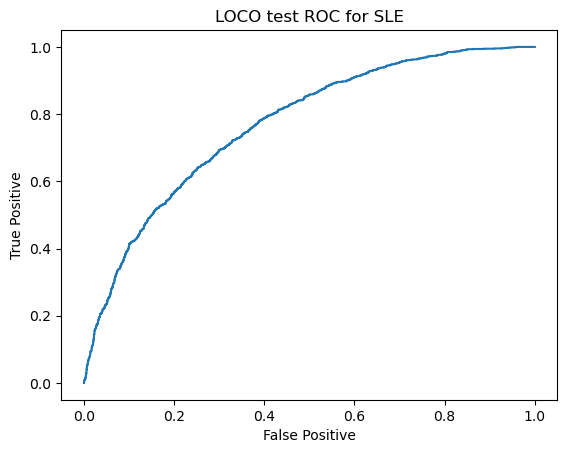

In [42]:
sle_auc = roc_auc(sle_image_preds, "SLE")

# COD

In [43]:
cod_pixelwise_preds, cod_image_preds = run_inference("COD")

Batch 0 Batch 5 Batch 10 Batch 15 Batch 20 Batch 25 Batch 30 Batch 35 Batch 40 Batch 45 Batch 50 Batch 55 Batch 60 Batch 65 Batch 70 Batch 75 Batch 80 Batch 85 Batch 90 Batch 95 Batch 100 Batch 105 Batch 110 Batch 115 

LOCO test AUC for COD is: 0.8249597746179436


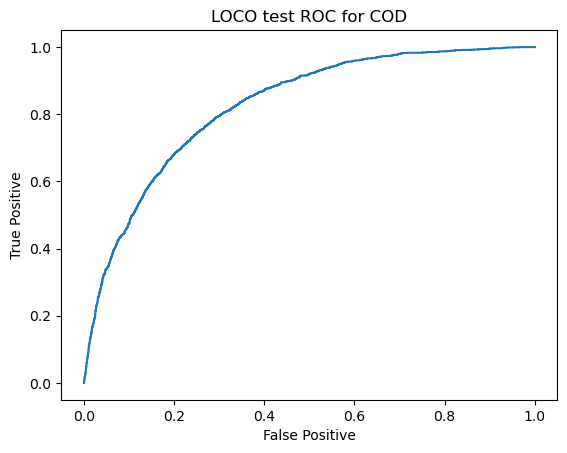

In [44]:
cod_auc = roc_auc(cod_image_preds, "COD")

In [46]:
del cod_pixelwise_preds
del sle_pixelwise_preds

# CAF

In [47]:
caf_pixelwise_preds, caf_image_preds = run_inference("CAF")

Batch 0 Batch 5 Batch 10 Batch 15 

LOCO test AUC for CAF is: 0.8179005615221064


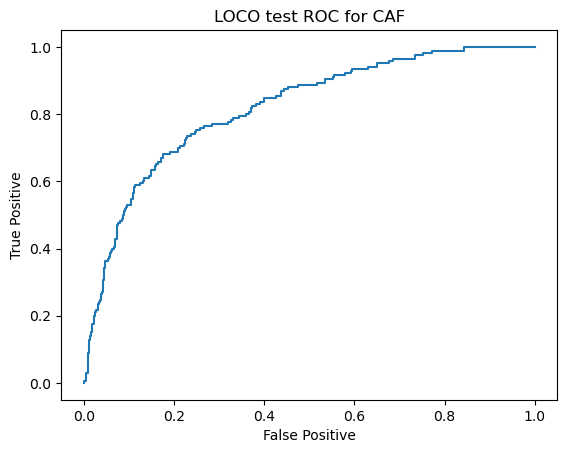

In [48]:
caf_auc = roc_auc(caf_image_preds, "CAF")

# ZWE

In [49]:
zwe_pixelwise_preds, zwe_image_preds = run_inference("ZWE")

Batch 0 Batch 5 

LOCO test AUC for ZWE is: 0.6915458937198068


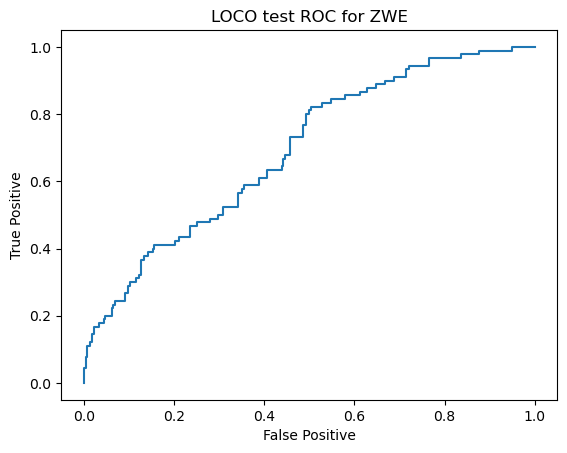

In [50]:
zwe_auc = roc_auc(zwe_image_preds, "ZWE")

In [51]:
del caf_pixelwise_preds
del zwe_pixelwise_preds

# TZA

In [58]:
tza_pixelwise_preds, tza_image_preds = run_inference("TZA")

Batch 0 Batch 5 Batch 10 Batch 15 

LOCO test AUC for TZA is: 0.7522996020627075


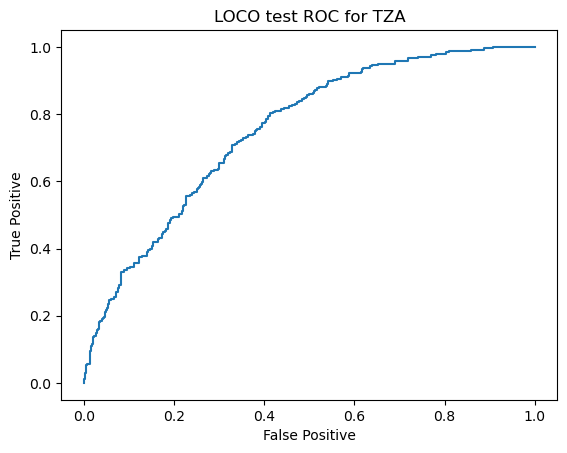

In [59]:
tza_auc = roc_auc(tza_image_preds, "TZA")